In [1]:
# Standard library
import datetime as dt
from pathlib import Path

# Third-party
import numpy as np
import pandas as pd
import requests
import scipy.io as sio

# Rutas

In [2]:
BASE_DIR = Path().resolve().parents[0]
DATA_RAW_DIR = BASE_DIR / "data" / "raw"
DATA_PROC_DIR = BASE_DIR / "data" / "processed"

# Carga de datos

In [3]:
url = "https://zenodo.org/records/10723261/files/Weather_data.mat"
path_data = DATA_RAW_DIR / "weather_data.mat"

In [4]:
if path_data.is_file():
    WS_data = sio.loadmat(path_data)
    print("Se carga el archivo .mat")

else:   
    response = requests.get(url)
    # Verificar que la descarga fue exitosa
    if response.status_code == 200:
        with open(path_data, "wb") as f:
            f.write(response.content)
        print(f"Archivo guardado como: {path_data}")
        WS_data = sio.loadmat(path_data)
        print("Se carga el archivo .mat")
    else:
        print(f"Error al descargar: {response.status_code}")

Se carga el archivo .mat


# Pre procesamiento

## numpy

In [5]:
# Convert date to continuous time: from date and time format to seconds
date_0 = WS_data['Date'][0]
date = []
for i in range(0, len(date_0)):
    date = np.append(date, str(date_0[i])[2 : -2])
time_init = dt.datetime(int(date[0][0 : 4]), int(date[0][5 : 7]), int(date[0][8 : 10]), int(date[0][11 : 13]), int(date[0][14 : 16]))
T_nan_index = np.argwhere(pd.isna(date))
date = np.delete(date, T_nan_index[:, 0],  0)
print('Double-check for NaN in time sequence', np.sum(pd.isna(date)))

Seconds = np.zeros((date.shape[0], 1))
for index in range(date.shape[0]):
    Seconds[index, 0] = ((dt.datetime(int(date[index][0 : 4]), int(date[index][5 : 7]), int(date[index][8 : 10]), int(date[index][11 : 13]), int(date[index][14 : 16])) - time_init).total_seconds())
T_WS = Seconds

Double-check for NaN in time sequence 0


In [6]:
# Convert to Cartesian coordinates
X_WS = np.array(6378000 * np.sin(np.radians(WS_data['Lon'])))[0]  # Longitude to meters
Y_WS = np.array(6378000 * np.sin(np.radians(WS_data['Lat'])))[0]  # Latitude to meters
Z_WS = np.array(WS_data['Alt'])[0]
Temp_WS = np.array(WS_data['Temperature'])[0]

In [7]:
# Project wind speed and direction into Cartesian coordinates
U_WS = (WS_data['WindSpeed'] * WS_data['WindDirectionX'])[0]
V_WS = (WS_data['WindSpeed'] * WS_data['WindDirectionY'])[0]

In [8]:
# Pressure from mbar to Pa
P_WS = WS_data['Pressure'][0] * 100

In [9]:
# Remove NaN values from time field
X_WS = np.delete(X_WS, T_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, T_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, T_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, T_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, T_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, T_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, T_nan_index[:, 0],  0)

In [10]:
# Structure data into matrix: 21 available stations (rows) x measurement every 10 min (column)
T_WS = np.reshape(T_WS, (int(T_WS.shape[0] / 21), 21)).T # There are 21 WS stations in this case
X_WS = np.reshape(X_WS, (T_WS.shape[1], T_WS.shape[0])).T
Y_WS = np.reshape(Y_WS, (T_WS.shape[1], T_WS.shape[0])).T
Z_WS = np.reshape(Z_WS, (T_WS.shape[1], T_WS.shape[0])).T
U_WS = np.reshape(U_WS, (T_WS.shape[1], T_WS.shape[0])).T
V_WS = np.reshape(V_WS, (T_WS.shape[1], T_WS.shape[0])).T
P_WS = np.reshape(P_WS, (T_WS.shape[1], T_WS.shape[0])).T
Temp_WS = np.reshape(Temp_WS, (T_WS.shape[1], T_WS.shape[0])).T
print('Number of weather stations:', T_WS.shape[0])

Number of weather stations: 21


In [11]:
# Remove NaN from location data
X_nan_index = np.argwhere(np.isnan(X_WS))
T_WS = np.delete(T_WS, X_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, X_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, X_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, X_nan_index[:, 0],  0)
X_WS = np.delete(X_WS, X_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, X_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, X_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, X_nan_index[:, 0],  0)
print('Double-check for NaN in location field', np.sum(np.isnan(X_WS)))

Double-check for NaN in location field 0


In [12]:
# Days selected for reconstruction
n_days = 14 # Change up to a maximum of 14 availsble days
samples =  int(144 * n_days) # Convert selected days to snapshots
T_WS = T_WS[:, : samples] 
X_WS = X_WS[:, : samples]
Y_WS = Y_WS[:, : samples]
Z_WS = Z_WS[:, : samples]
U_WS = U_WS[:, : samples]
V_WS = V_WS[:, : samples]
P_WS = P_WS[:, : samples]
Temp_WS = Temp_WS[:, : samples]

In [13]:
# Sort values in matrix into increasing values of X coordinate
for snap in range(0, T_WS.shape[1]):
    index_sort = np.argsort(X_WS[:, snap])
    T_WS[:, snap] = T_WS[index_sort, snap]
    X_WS[:, snap] = X_WS[index_sort, snap]
    Y_WS[:, snap] = Y_WS[index_sort, snap]
    Z_WS[:, snap] = Z_WS[index_sort, snap]
    U_WS[:, snap] = U_WS[index_sort, snap]
    V_WS[:, snap] = V_WS[index_sort, snap]
    P_WS[:, snap] = P_WS[index_sort, snap]
    Temp_WS[:, snap] = Temp_WS[index_sort, snap]

In [14]:
# Delete NaN from U, V and P if constantly occuring for each weather station
uvp_mean = np.nanmean(np.concatenate([U_WS, V_WS, P_WS], axis = 1), axis = 1)[:, None]
vel_nan_index = np.argwhere(np.isnan(uvp_mean))
T_WS = np.delete(T_WS, vel_nan_index[:, 0],  0)
P_WS = np.delete(P_WS, vel_nan_index[:, 0],  0)
U_WS = np.delete(U_WS, vel_nan_index[:, 0],  0)
V_WS = np.delete(V_WS, vel_nan_index[:, 0],  0)
X_WS = np.delete(X_WS, vel_nan_index[:, 0],  0)
Y_WS = np.delete(Y_WS, vel_nan_index[:, 0],  0)
Z_WS = np.delete(Z_WS, vel_nan_index[:, 0],  0)
Temp_WS = np.delete(Temp_WS, vel_nan_index[:, 0],  0)

In [15]:
# Correct pressure to sea level (ISA)
P_WS = P_WS * (1 - 0.0065 * Z_WS / (Temp_WS + 273.15 + 0.0065 * Z_WS))**(-5.257)

In [16]:
# Certering of location and time fields
x_min = np.min(X_WS)
x_max = np.max(X_WS)
X_WS = X_WS - (x_min + x_max) / 2
y_min = np.min(Y_WS)
y_max = np.max(Y_WS)
Y_WS = Y_WS - (y_min + y_max) / 2
t_min = np.min(T_WS)
t_max = np.max(T_WS)
T_WS = T_WS - t_min # Refer to t = 0

In [17]:
# PINN output grid
T_PINN = T_WS[0 : 1, :] # Same times for reconstruction

In [18]:
# Resolution in degrees
R = 0.2
R_PINN = 6378000 * np.sin(np.radians(R)) # Grid resolution
x_PINN = np.arange(x_min - R_PINN, x_max + R_PINN, R_PINN) # X values in output resolution
y_PINN = np.arange(y_min - R_PINN, y_max + R_PINN, R_PINN) # Y values in output resolution

In [19]:
# Centering of location data
x_PINN = x_PINN - (x_min + x_max) / 2
y_PINN = y_PINN - (y_min + y_max) / 2

In [20]:
# Final output grid
X_PINN, Y_PINN = np.meshgrid(x_PINN, y_PINN)
X_PINN = X_PINN.flatten('F')[:, None]
Y_PINN = Y_PINN.flatten('F')[:, None]

In [21]:
# Dimensions
dim_T_PINN = T_PINN.shape[1]
dim_N_PINN = X_PINN.shape[0]

T_PINN = np.tile(T_PINN, (dim_N_PINN, 1))
X_PINN = np.tile(X_PINN, dim_T_PINN)
Y_PINN = np.tile(Y_PINN, dim_T_PINN)

In [22]:
# Reference values for non-dimensionalization
L = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2) # Reference distance
W = np.sqrt(np.nanmax(abs(U_WS)) ** 2 + np.nanmax(abs(V_WS)) ** 2) # Reference velocity
rho = 1.269 # Air density at 15 degrees
nu = 1.382e-5 # Kinematic viscosity at 15 degrees
Re = int(W * L / nu) # Reynolds number
P0 = np.nanmean(P_WS) # Reference pressure level
print('L:', L, 'W', W, 'P0', P0, 'Re', Re)

L: 409791.6159110926 W 16.718180196652117 P0 100359.48707895375 Re 495728659759


In [23]:
# Non-dimensionalization
X_WS = X_WS / L
Y_WS = Y_WS / L
T_WS = T_WS * W / L
P_WS = (P_WS - P0) / rho / (W ** 2)
U_WS = U_WS / W
V_WS = V_WS / W

X_PINN = X_PINN / L
Y_PINN = Y_PINN / L
T_PINN = T_PINN * W / L

In [24]:
print(f"{X_WS.shape=}")
print(f"{Y_WS.shape=}")
print(f"{T_WS.shape=}")
print(f"{P_WS.shape=}")
print(f"{U_WS.shape=}")
print(f"{V_WS.shape=}")
print(f"{X_PINN.shape=}")
print(f"{Y_PINN.shape=}")
print(f"{T_PINN.shape=}")

X_WS.shape=(21, 2016)
Y_WS.shape=(21, 2016)
T_WS.shape=(21, 2016)
P_WS.shape=(21, 2016)
U_WS.shape=(21, 2016)
V_WS.shape=(21, 2016)
X_PINN.shape=(160, 2016)
Y_PINN.shape=(160, 2016)
T_PINN.shape=(160, 2016)


In [25]:
# Validation cases (remove stations)
# # N_test = 0 # Number of stations to remove
WS_val = np.array([1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16, 19])
# Choose between different arrays for desired validation case:
# Close: np.array([2, 8, 10, 14, 16, 19])
# Far: np.array([0, 1, 4, 6, 8, 12, 17, 18, 19, 20]) 
# Envelope: np.array([1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16, 19])

In [26]:
# Remove WS for validation
T_val = T_WS[WS_val, :]
P_val = P_WS[WS_val, :]
U_val = U_WS[WS_val, :]
V_val = V_WS[WS_val, :]
X_val = X_WS[WS_val, :]
Y_val = Y_WS[WS_val, :]
Z_val = Z_WS[WS_val, :]

In [27]:
# Remaining Ws for training
T_WS = np.delete(T_WS, WS_val, 0)
P_WS = np.delete(P_WS, WS_val, 0)
U_WS = np.delete(U_WS, WS_val, 0)
V_WS = np.delete(V_WS, WS_val, 0)
X_WS = np.delete(X_WS, WS_val, 0)
Y_WS = np.delete(Y_WS, WS_val, 0)
print('Number of final weather stations available for training:', T_WS.shape[0])

Number of final weather stations available for training: 8


In [28]:
# Dimensions
dim_N_WS = X_WS.shape[0]
dim_T_WS = X_WS.shape[1]

In [29]:
print(f"{dim_T_PINN=}")
print(f"{dim_N_PINN=}")
print(20*"*")
print(f"{dim_N_WS=}")
print(f"{dim_T_WS=}")
# Data dimensions
dim_N_data = dim_N_WS
dim_T_data = dim_T_WS
dim_T_eqns = dim_T_PINN
dim_N_eqns = dim_N_PINN
print(20*"*")
print(20*"*")
print(f"{dim_N_data=}")
print(f"{dim_T_data=}")
print(20*"*")
print(f"{dim_T_eqns=}")
print(f"{dim_N_eqns=}")

dim_T_PINN=2016
dim_N_PINN=160
********************
dim_N_WS=8
dim_T_WS=2016
********************
********************
dim_N_data=8
dim_T_data=2016
********************
dim_T_eqns=2016
dim_N_eqns=160


In [30]:
batch_PINN = int(np.ceil((dim_N_PINN * dim_T_PINN / n_days * R)))
batch_WS = int(np.ceil(dim_N_WS * dim_T_WS / n_days * R))

In [31]:
print(f"{batch_PINN=} - {batch_WS=}")

batch_PINN=4608 - batch_WS=231


-----------------------------------------------------------------------------------------------------------

In [38]:
# Third-party
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

In [39]:
path_pinn_1000 = "../data.csv"

In [40]:
df_60 = pd.read_csv(path_pinn_1000, sep=";")

In [41]:
df_60.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Epoch          60 non-null     int64  
 1   Loss training  60 non-null     float64
 2   NS_Loss        60 non-null     float64
 3   U_Loss         60 non-null     float64
 4   V_Loss         60 non-null     float64
 5   P_Loss         60 non-null     float64
 6   learning rate  60 non-null     float64
 7   time           60 non-null     float64
 8   Unnamed: 8     60 non-null     object 
dtypes: float64(7), int64(1), object(1)
memory usage: 4.3+ KB


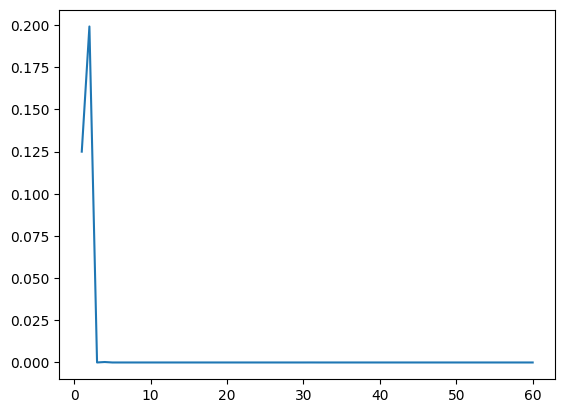

In [43]:
col_var = "NS_Loss"
x = df_60.loc[:, "Epoch"]
y = df_60.loc[:, col_var]

plt.plot(x,y)

In [44]:
df_1k = sio.loadmat("../data/Brussels_1000_lambda_2_R_0.2_envelope.mat")

In [45]:
for k in df_1k.keys(): print(k)

__header__
__version__
__globals__
T_PINN
X_PINN
Y_PINN
U_PINN
V_PINN
P_PINN
T_WS
X_WS
Y_WS
U_WS
V_WS
P_WS
U_WS_pred
V_WS_pred
P_WS_pred
T_val
X_val
Y_val
U_val
V_val
P_val
U_val_pred
V_val_pred
P_valt_pred
Train_loss
NS_loss
P_loss
U_loss
V_loss


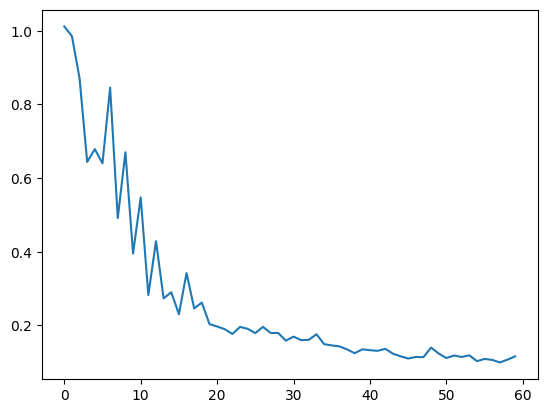

In [46]:
col_var = "P_loss"
y = df_1k[col_var][0][:60]
x = range(len(y))

plt.plot(x,y)